In [3]:
# Standard API
import collections
import os
import math
import torch
import pandas as pd
import numpy as np
from torch import nn
from d2l import torch as d2l
import random
import csv
import matplotlib.pyplot as plt

# User defined API
from ReadingRawGnssDataset import readingRawGnssDataset
from PrNet_parallel import MlpFeatureExtractor
from PrNet_parallel import PrNet
from train_PrNet_parallel import train_gnss_net
from DataLoader_MultipleFile_Random_NoTime import GnssMultipleDataFileLoader
from DataLoader_SingleFile_NoTime import GNSSSingleDataFileLoader
from Evaluate_PrNet_parallel import evaluate_gnss_net

# Set the global data type
torch.set_default_tensor_type(torch.DoubleTensor)

# Main Function

In [5]:
# %% *********************************** Parameter Settings ***********************************
# A minibatch is organized in a tensor with size [batch_size * PRN_size * Input_size]
# Input size of rural data
input_size = 39

# Input size of urban data
# input_size = 55

PRN_size = 32
res_size = 1
label_size = 3

# %% *********************************** Reading training data in multiple data files ***********************************
training_data_dir = "../Data/RouteR/Training/"
# Get all files in the current directory
training_data_files = os.listdir(training_data_dir)
Xfeatures_list = []
Reslabels_list = []
ylabels_list = []
for data_file in training_data_files:
    # If the object is not a directory, we will open and read it
    data_file_path = training_data_dir+'/'+data_file
    if not os.path.isdir(data_file_path):
        # Read one data file
        data = pd.read_csv(data_file_path)
        inputs, outputs = torch.tensor(data.iloc[:, 0:input_size].values), torch.tensor(data.iloc[:, 14:input_size].values)
        # features, pseudorange residuals, labels
        Xfeatures, Reslabels, ylabels = readingRawGnssDataset(inputs, outputs, input_size, res_size, label_size,
                                                              PRN_size)  # a list of tensors
        # Lists of input data files
        Xfeatures_list.append(Xfeatures)
        Reslabels_list.append(Reslabels)
        ylabels_list.append(ylabels)

sum_samples = 0
for data_file in training_data_files:
    # If the object is not a directory, we will open and read it
    data_file_path = training_data_dir+'/'+data_file
    if not os.path.isdir(data_file_path):
        # Read one data file
        data = pd.read_csv(data_file_path)
        sum_samples = sum_samples+len(data.iloc[:,:].values)
sum_samples


185822

# Initialize a Model

In [6]:
# %%  *********************************** PrNet ***********************************
# Size of input features of Encoder's MLP
# CN0, sinE, cosE, PRN, Wls_lon*3, Wls_lat*3, Unit_geometry_vector*3, heading*3
input_size_debiasing = 16 

# Number of hidden neurons on the hidden layer of the MLP
#H
num_hiddens_debiasing = 40

# Number of layers of the MLP
#L
num_debiasing_layers = 20

# Dropout probability
dropout = 0
extractor = MlpFeatureExtractor(input_size_debiasing, num_hiddens_debiasing, 
                                num_debiasing_layers, dropout=0)
net = PrNet(extractor)

# Training Process

In [ ]:
"""Training"""
# batch size in rural areas
batch_size = 256 

# batch size in urban areas
# batch_size = 32

# Define data iterator
data_iter = GnssMultipleDataFileLoader(Xfeatures_list, Reslabels_list, batch_size)

num_epochs_seq = [100, 100, 100, 100, 100]
num_iterations = 1
lr = 0.01
for num_epochs in num_epochs_seq:
    optimizer = train_gnss_net(net, data_iter, lr, num_epochs, num_iterations, d2l.try_gpu())
    lr = lr/10

torch.save({
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'PrNet_Layer20_H40_heading_RouteR_500.tar')

# Evaluation Process

Inference time per sample:  0.023097758784013635


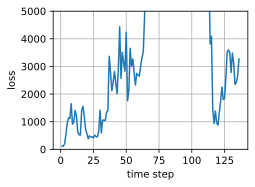

In [7]:
# A minibatch is organized in a tensor with size [batch_size * PRN_size * Input_size]
# Input size of rural data
input_size = 39

# Input size of urban data
# input_size = 55

PRN_size = 32
res_size = 1
label_size = 3

# A minibatch is organized in a tensor with size [batch_size * MovingWindowSize * PRN_size * Input_size]
batch_size_eval = 1

# %% *********************************** Reading testing data  ***********************************
data_file_eval = "../Data/RouteR/Testing/SvPVT3D_Error_label_dynamic_2020-05-14-US-MTV-1.csv"
data_eval = pd.read_csv(data_file_eval)

inputs_eval, outputs_eval = torch.tensor(data_eval.iloc[:, 0:input_size].values), torch.tensor(data_eval.iloc[:, 14:input_size].values)

# features, pseudorange residuals, labels
x_features_eval, res_labels_eval, y_labels_eval = readingRawGnssDataset(inputs_eval, outputs_eval, input_size, res_size,
                                                                        label_size, PRN_size)  # a list of tensors
plt.figure()
plt.plot(torch.stack([sum(y[y[:,0]!=0, 0])/sum(y[:,0]!=0) for y in y_labels_eval]),
         torch.stack([sum(y[y[:,0]!=0, 1])/sum(y[:,0]!=0) for y in y_labels_eval]), 'v')         
plt.show()

# Define the data iterator for evaluation
data_iter_eval = GNSSSingleDataFileLoader(x_features_eval, res_labels_eval, batch_size_eval)


# %%  *********************************** PrNet ***********************************
# Size of input features of Encoder's MLP
# CN0, sinE, cosE, PRN, Wls_lon*3, Wls_lat*3, Unit_geometry_vector*3, heading*3
input_size_debiasing = 16 
# 16 

# Number of hidden neurons on the hidden layer of the Encoder's MLP
num_hiddens_debiasing = 40 

# Number of layers of the Encoder's MLP
num_debiasing_layers = 20 

extractor = MlpFeatureExtractor(input_size_debiasing, num_hiddens_debiasing, num_debiasing_layers, dropout = 0)
model_eval = PrNet(extractor)

# The number of trainable parameters
pytorch_total_params = sum(p.numel() for p in model_eval.parameters() if p.requires_grad)
print(pytorch_total_params)

# Load the trained PrNet.tar
checkpoint = torch.load('Weights/RouteR/PrNet_Layer20_H40_heading_RouteR_500.tar')
model_eval.load_state_dict(checkpoint['model_state_dict'])

# Evaluation
model_eval.eval()
prm_bias = evaluate_gnss_net(model_eval, data_iter_eval, batch_size_eval, d2l.try_gpu())

# Write debiased results to a .csv file
prm_bias_np = prm_bias.cpu().detach().numpy()
prm_bias_np_df = pd.DataFrame(prm_bias_np)
prm_bias_np_df.to_csv('PrM_Bias_2020-05-14-US-MTV-1.csv',header=False)